# Строврення QSAR моделі для альфа ІІ казеїн кінази
---

### Препроцесинг
Завантажуємо необхідні бібліотеки

In [8]:
import numpy as np
import scipy
import pandas as pd

from os import listdir
from os.path import isfile, join
from os import walk

In [2]:
# load the plotting libraries, in case needed
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting parameters
large = 20; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
%matplotlib inline

Завантажуємо датасет

In [35]:
primarydf = pd.read_csv('Kasein.csv', sep = ';')
primarydf.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1096626,GSK-938890A,None,447.50,0,2.28,GSK938890A,CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)nc(OC[C@@H](N...,Inhibition,'=',...,SINGLE PROTEIN,CHEMBL1961873,16,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN,NaN,NaN
1,CHEMBL572878,TOZASERTIB,2.0,464.60,0,3.50,VX-680/MK-0457,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,Kd,'>',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,None,NaN,NaN,NaN
2,CHEMBL189353,GW809897X,None,571.49,2,6.48,GW809897X,CN(c1ccc(NC(=O)Nc2c(Cl)cccc2Cl)cc1)c1ccnc(Nc2c...,Inhibition,'=',...,SINGLE PROTEIN,CHEMBL1961873,16,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN,NaN,NaN
3,CHEMBL270544,GW396574X,None,370.43,0,2.53,GW396574X,CC(C)=Cc1cccc2c1/C(=N/Nc1ccc(S(N)(=O)=O)cc1)C(...,Inhibition,'=',...,SINGLE PROTEIN,CHEMBL1961873,16,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN,NaN,NaN
4,CHEMBL1934353,NaN,None,568.10,1,3.85,14b,CN(c1ccccc1-c1cc(Cl)c2cnc(Nc3ccc(C4CCN(CC(N)=O...,Inhibition,'=',...,SINGLE PROTEIN,CHEMBL1932974,1,Scientific Literature,Bioorg Med Chem Lett,2012.0,None,NaN,NaN,NaN


Обираємо необідні колонки

In [36]:
primarydf = primarydf[['Smiles', 'Standard Type', 'Standard Value', 'Standard Units']]

Залишаємо дані з  ІС50

In [37]:
primarydf = primarydf[primarydf['Standard Type'].isin(['IC50'])]

Логарифмування

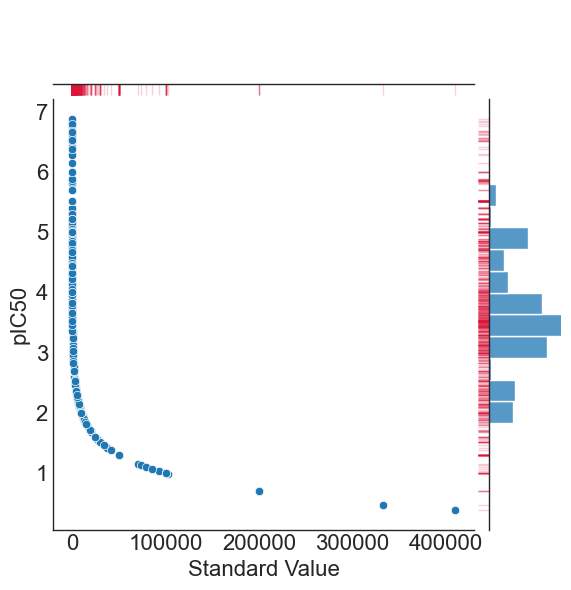

In [38]:
from optunaz.utils.preprocessing.transform import (
    LogBase,
    LogNegative,
    ModelDataTransform
)

transform = ModelDataTransform.new(
    base=LogBase.LOG10,
    negation=LogNegative.TRUE,
    conversion=6
)

primarydf['pIC50'] = transform.transform(primarydf['Standard Value'])

g = sns.jointplot(data=primarydf, x='Standard Value', y="pIC50")
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

In [39]:
from optunaz.utils.preprocessing.deduplicator import *

col = "Smiles"

#df_pos = KeepFirst().dedup(primarydf, col)
#df_rnd = KeepRandom().dedup(primarydf, col)
#df_max = KeepMax().dedup(primarydf, col)
#df_avg = KeepAvg().dedup(primarydf, col)
df_med = KeepMedian().dedup(primarydf, col)

# print sizes
print(f"original: {len(primarydf)}, deduplidcated: {len(df_med)}")

original: 958, deduplidcated: 723


Порівняємо різні способи дедуплікації

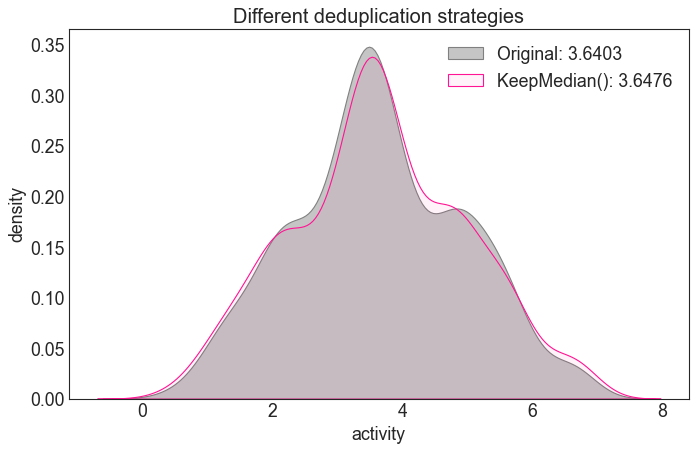

In [40]:
# make a density plot to compare the strategies
plt.figure(figsize=(10,6), dpi=80)

plt.xlabel("activity")
plt.ylabel("density")
plt.title("Different deduplication strategies", fontsize=18)
sns.kdeplot(primarydf["pIC50"], fill=True, color="grey", alpha=0.45,
            label = "Original: %s" % round(primarydf["pIC50"].mean(), ndigits=4))
sns.kdeplot(df_med["pIC50"], fill=True, color="deeppink", alpha=0.05,
            label = "KeepMedian(): %s" % round(df_med["pIC50"].mean(), ndigits=4))
# do the legend and render
plt.legend(loc="upper right")
plt.show()

In [41]:
df = df_med.dropna().reset_index()

In [43]:
#standard deviation across compound replicates 
std_df = primarydf.groupby("Smiles").std()
#median across compound replicates 
mdn_df = primarydf.groupby("Smiles").median()
#create dataframe between standard deviation and the median across replicates 
std_vs_median=std_df.merge(mdn_df,on="Smiles", suffixes=["_std", "_median"]).dropna()
#show example of replicate data
std_vs_median=std_vs_median.reset_index(drop=True)
std_vs_median.index.name='Compound Index'
std_vs_median

C:\Users\Nazar\AppData\Local\Temp\ipykernel_2820\4031421929.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_df = primarydf.groupby("Smiles").std()
C:\Users\Nazar\AppData\Local\Temp\ipykernel_2820\4031421929.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mdn_df = primarydf.groupby("Smiles").median()


,Standard Value_std,pIC50_std,Standard Value_median,pIC50_median
Compound Index,,,,
0,799.030663,0.624725,735.0,3.327804
1,464.973118,0.258884,500.0,3.301030
2,12.727922,0.042263,131.0,3.883756
3,16.263456,0.189226,38.5,4.434833
4,72.831998,0.718076,62.5,4.450851
...,...,...,...,...
141,3998.688848,1.331548,2902.5,3.183392
142,43.840620,0.103897,185.0,3.739013
143,240.416306,0.238254,460.0,3.369131


In [44]:
median=std_vs_median["pIC50_median"].mean().round(2)
stdev=std_vs_median["pIC50_std"].mean().round(2)
print(f'Standard deviation of experimental results:{stdev}')
print(f'Median of experimental results:{median}')

Standard deviation of experimental results:0.59
Median of experimental results:3.54


In [ ]:
import scipy
from scipy import stats

#r2 for activity dependent error analysis plot
def r2(x, y):
    return np.round(stats.pearsonr(x, y)[0] ** 2,2)

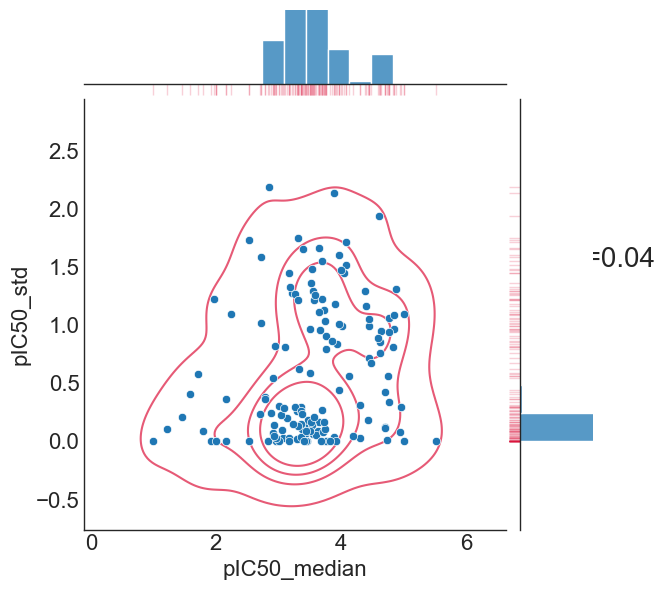

In [45]:
#r2 of median vs. std
stat_func = r2(std_vs_median["pIC50_median"], std_vs_median["pIC50_std"])

#plot median vs. std dev
g = sns.jointplot(data=std_vs_median, x="pIC50_median", y="pIC50_std")
g.ax_joint.text(x=7.5,y=1.5,s=f"r2={stat_func}",fontsize=20)
g.plot_joint(sns.kdeplot, color="crimson", zorder=0, levels=5,alpha=.7)
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

In [46]:
from optunaz.utils.preprocessing.splitter import *

train_ran, test_ran = Random(fraction=0.3, seed=42).split(df["Smiles"]) #random split
train_str, test_str = Stratified(fraction=0.4, seed=42, bins="fd").split(df["Smiles"], df["pIC50"]) #stratified split
train_temporal, test_temporal = Temporal(fraction=0.1).split(df["Smiles"]) #temporal split

#scaffold split
scaf_split = ScaffoldSplit()
scaffolds = scaf_split.groups(df, "Smiles")
groups = df["Smiles"].map(scaffolds)
train_sca, test_sca = scaf_split.split(df["Smiles"], df["pIC50"], groups=groups)

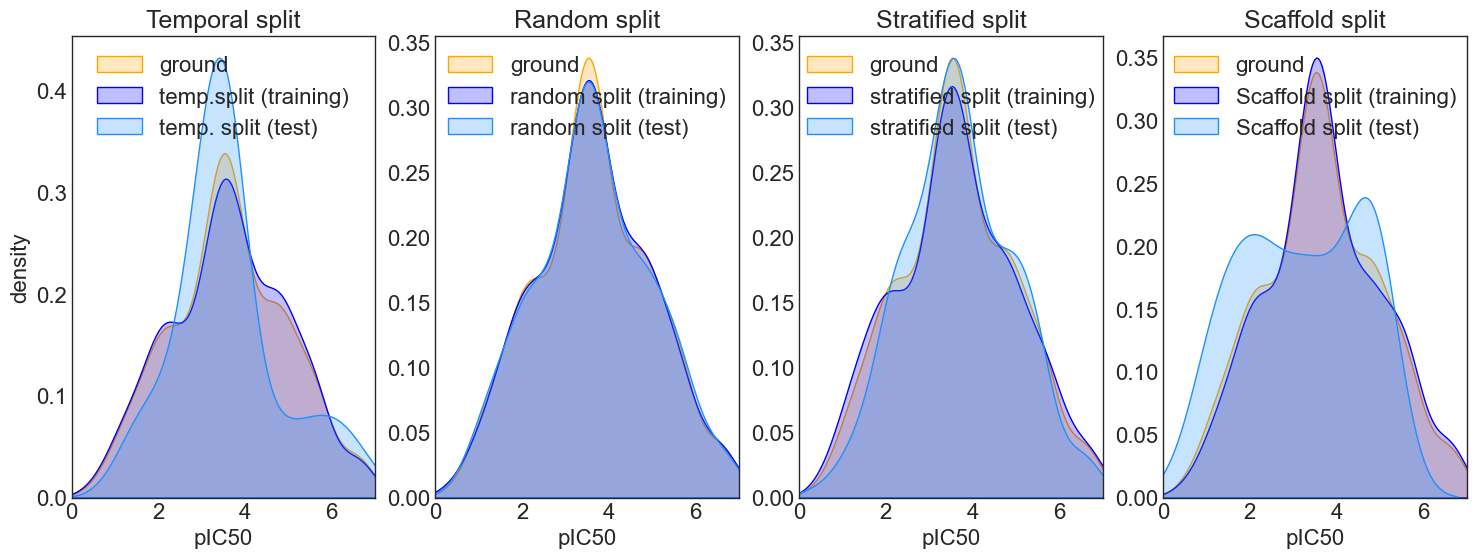

In [48]:
# make a density plot to compare the strategies
plt.figure(figsize=(18,6), dpi=100)

# left plot
plt.subplot(1, 4, 1)
plt.xlabel(f"pIC50")
plt.ylabel("density")
plt.title("Temporal split", fontsize=18)
sns.kdeplot(df["pIC50"], fill=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df.loc[train_temporal]["pIC50"], fill=True, color="blue", label="temp.split (training)", alpha=0.25)
sns.kdeplot(df.loc[test_temporal]["pIC50"], fill=True, color="dodgerblue", label="temp. split (test)", warn_singular=False, alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,7)

# middle left plot
plt.subplot(1, 4, 2)
plt.xlabel(f"pIC50")
plt.ylabel(" ")
plt.title("Random split", fontsize=18)
sns.kdeplot(df["pIC50"], fill=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df.loc[train_str]["pIC50"], fill=True, color="blue", label="random split (training)", alpha=0.25)
sns.kdeplot(df.loc[test_str]["pIC50"], fill=True, color="dodgerblue", label="random split (test)", warn_singular=False, alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,7)

# middle right plot

plt.subplot(1, 4, 3)
plt.xlabel(f"pIC50")
plt.ylabel(" ")
plt.title("Stratified split", fontsize=18)
sns.kdeplot(df["pIC50"], fill=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df.loc[train_ran]["pIC50"], fill=True, color="blue", label="stratified split (training)", alpha=0.25)
sns.kdeplot(df.loc[test_ran]["pIC50"], fill=True, color="dodgerblue", label="stratified split (test)", warn_singular=False, alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,7)

# right plot
plt.subplot(1,4,4)
plt.xlabel(f"pIC50")
plt.ylabel(" ")
plt.title("Scaffold split", fontsize=18)
sns.kdeplot(df["pIC50"], fill=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df.loc[train_sca]["pIC50"], fill=True, color="blue", label="Scaffold split (training)", alpha=0.25)
sns.kdeplot(df.loc[test_sca]["pIC50"], fill=True, color="dodgerblue", label="Scaffold split (test)", warn_singular=False, alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,7)

# do the legend and render
plt.show()

In [49]:
df['activity'] = df['pIC50'] < median

In [51]:
from optunaz.utils.preprocessing.splitter import Random

train, test = Random(fraction=0.3, seed=42).split(df['Smiles']) #random split

train = df.loc[train]
test = df.loc[test]

train.to_csv('train.csv')
test.to_csv('test.csv')

## QSAR моделювання
### Регресія
Завантажуємо пакети

In [5]:
# Start with the imports.
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor,
    XGBRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

In [54]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="Smiles",  # Typical names are "SMILES" and "smiles".
        response_column="pIC50",  # Often a specific name (like here), or just "activity".
        training_dataset_file='train.csv',
        test_dataset_file='test.csv',  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        MACCS_keys.new(),
        PathFP.new()
    ],
    algorithms=[
        SVR.new(C = {'low':1e-10, 'high':100}, gamma = {'low':0.001, 'high':100}),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        XGBRegressor.new(max_depth={'low':2, 'high':10}, n_estimators={'low':10, 'high':200})
        #PLSRegression.new(n_components = {'low':2, 'high':5}),
        #KNeighborsRegressor.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=5,
        n_trials=50,  # Total number of trials.
        n_startup_trials=25,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

In [55]:
study = optimize(config, study_name="my_study")

[I 2024-07-23 21:55:51,583] A new study created in memory with name: my_study
[I 2024-07-23 21:55:51,737] A new study created in memory with name: study_name_0
[I 2024-07-23 21:55:53,479] Trial 0 finished with value: -0.7241331098451387 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 20, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 0 with value: -0.7241331098451387.
[I 2024-07-23 21:55:55,250] Trial 1 finished with value: -0.596150343914721 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 32, 'n_estimators__f1ac01e1bba332215ccbd0c

Duplicated trial: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 9, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 170, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-0.5587644527231878]


[I 2024-07-23 21:57:41,323] Trial 84 finished with value: -0.5587644543132717 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 9, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 164, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.5328162158694788.
[I 2024-07-23 21:57:47,605] Trial 85 finished with value: -0.5587644545782909 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 9, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 163, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.53

Duplicated trial: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 9, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 163, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-0.5587644545782909]


[I 2024-07-23 21:57:54,621] Trial 87 finished with value: -0.5709929135153595 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 10, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 161, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.5328162158694788.
[I 2024-07-23 21:58:00,679] Trial 88 finished with value: -0.5587644566984984 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 9, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 155, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.5

Duplicated trial: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 8, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 176, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-0.5563093663879832]


[I 2024-07-23 21:58:18,907] Trial 92 finished with value: -0.5328675705218278 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 7, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 177, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.5328162158694788.
[I 2024-07-23 21:58:24,646] Trial 93 finished with value: -0.5328675695573801 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 7, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 181, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.53

Duplicated trial: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 7, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 197, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-0.5328675668110161]


[I 2024-07-23 21:58:54,433] Trial 99 finished with value: -0.5328675668110161 and parameters: {'algorithm_name': 'XGBRegressor', 'XGBRegressor_algorithm_hash': '06f3e55e39df10b23fbf7ef739772513', 'max_depth__06f3e55e39df10b23fbf7ef739772513': 7, 'n_estimators__06f3e55e39df10b23fbf7ef739772513': 198, 'learning_rate__06f3e55e39df10b23fbf7ef739772513': 0.1, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 56 with value: -0.5328162158694788.


In [56]:
buildconfig = buildconfig_best(study)

In [57]:
best_build = build_best(buildconfig, "best_regressor.pkl")

In [59]:
import pickle
with open("best_regressor.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([2.44302344, 3.1991303 ])

In [60]:
#df = pd.read_csv(config.data.test_dataset_file)  # Load test data.

expected = test[config.data.response_column]
predicted = model.predict_from_smiles(test[config.data.input_column])

Text(0, 0.5, 'Predicted pIC50')

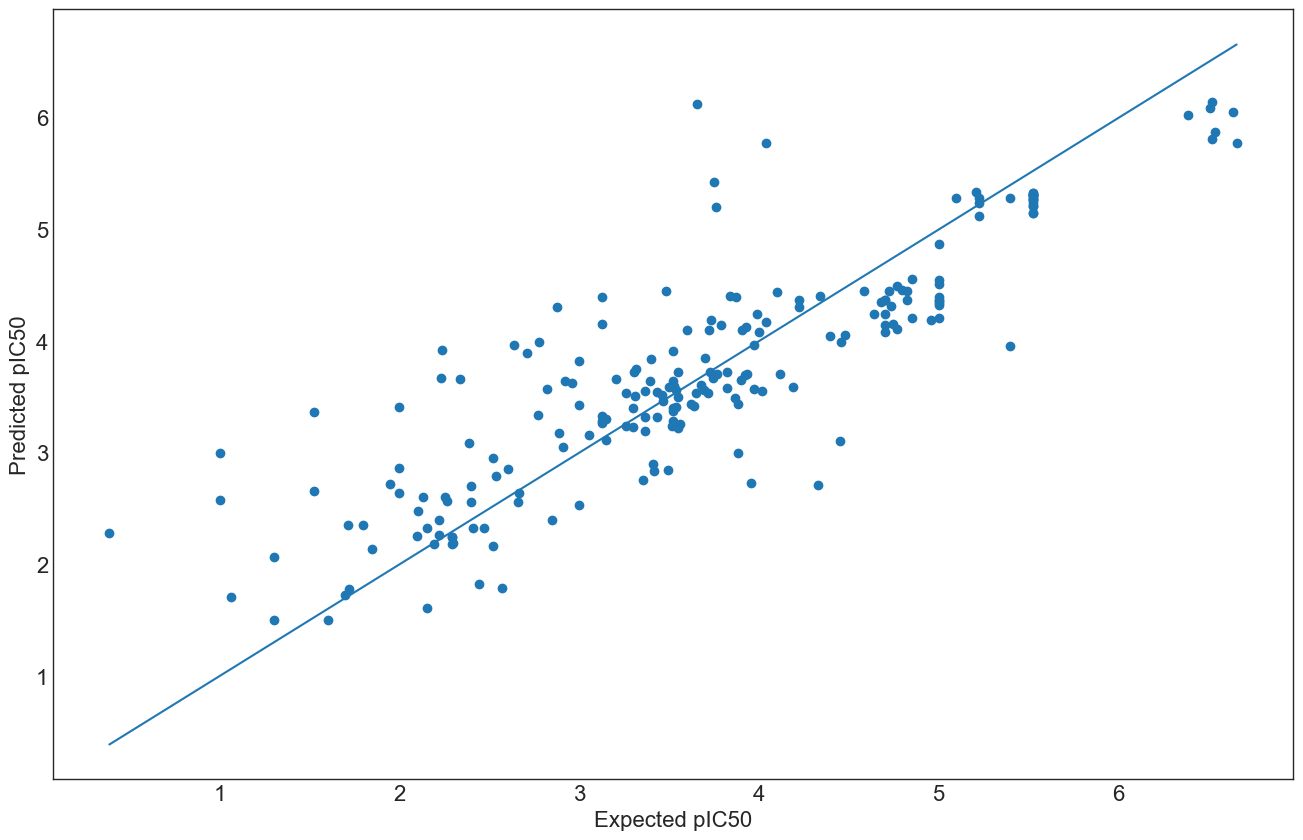

In [61]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt # type: ignore
ax = plt.scatter(expected, predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}")
plt.ylabel(f"Predicted {config.data.response_column}")

In [62]:
model.predict_from_smiles(test[config.data.input_column], explain=True).query('shap_value > 0').head(10)

,shap_value,descriptor,bit,info
412,0.649872,ECFP,412,n(c)(n)c
491,0.141767,ECFP,491,N(c)c
873,0.120259,ECFP,873,[nH](c(-c)n)nn
1535,0.101836,ECFP,1535,c(c)n
1984,0.086328,ECFP,1984,c1(C(=O)O)cc(n)ccc1
21,0.053831,ECFP,21,c1(NCC)nccc(c)n1
1733,0.042839,ECFP,1733,c(cc)c(c)c
1745,0.039070,ECFP,1745,c1cc(N)cc(N)c1OC
378,0.038975,ECFP,378,N1(c(cc)c(c)Cl)CCCC(O)C1
119,0.031168,ECFP,119,C(C)(O)C


In [63]:
model.metadata['test_scores']

{'explained_variance': 0.7445034261856921,
 'max_error': -2.46761956571619,
 'neg_mean_absolute_error': -0.45113759617305804,
 'neg_mean_squared_error': -0.39617913254286613,
 'neg_median_absolute_error': -0.3268314178515297,
 'r2': 0.7428009920061867}

### Класифікація

In [4]:
import pickle

from optunaz.config.optconfig import (
    AdaBoostClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
    SVC)

In [9]:
config = OptimizationConfig(
    data=Dataset(
        input_column="Smiles",
        response_column="activity",
        training_dataset_file="train.csv",
        test_dataset_file='test.csv'),
    descriptors=[ECFP.new()],
    algorithms=[ 
        RandomForestClassifier.new(max_depth={'low':5, 'high':20}, n_estimators={"low": 5, "high": 10}),
        AdaBoostClassifier.new(n_estimators={'low':10, 'high':200}),
        #SVC.new(C = {'low':1e-7, 'high':10}, gamma = {'low':0.01, 'high':10}),
        KNeighborsClassifier.new(n_neighbors={'low':3, 'high':10})
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=50,
        n_startup_trials=30,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

study = optimize(config, study_name="classifier")

[I 2024-07-23 23:26:07,690] A new study created in memory with name: classifier
[I 2024-07-23 23:26:08,019] A new study created in memory with name: study_name_0
[I 2024-07-23 23:26:14,784] Trial 0 finished with value: 0.8845983915097199 and parameters: {'algorithm_name': 'AdaBoostClassifier', 'AdaBoostClassifier_algorithm_hash': 'f5042fca93c663640b8ca8e573cbbe00', 'n_estimators__f5042fca93c663640b8ca8e573cbbe00': 124, 'learning_rate__f5042fca93c663640b8ca8e573cbbe00': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: 0.8845983915097199.
[I 2024-07-23 23:26:15,764] Trial 1 finished with value: 0.8635740308902846 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '158bf1698fd6fd47a9d948d478940096', 'max_depth__158bf1698fd6fd47a9d948d478940096': 18, 'n_estimators__158bf1698fd6fd47a9d948d478940096': 8, 'max_features__158bf1698fd6fd47a9d948d478940096': <Ran

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 9, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8888847744323062]


[I 2024-07-23 23:26:18,911] Trial 6 finished with value: 0.8876343952328103 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 3, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 4 with value: 0.8957003400183329.
[I 2024-07-23 23:26:19,556] Trial 7 finished with value: 0.876010630305563 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '158bf1698fd6fd47a9d948d478940096', 'max_depth__158bf1698fd6fd47a9d948d478940096': 20, 'n_estimators__158bf1698fd6fd47a9d948d478940096': 10, 'max_features__158bf1698fd6fd47a9d948d478940096': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descript

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 9, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8888847744323062]


[I 2024-07-23 23:26:32,922] Trial 12 finished with value: 0.8471962762252077 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '158bf1698fd6fd47a9d948d478940096', 'max_depth__158bf1698fd6fd47a9d948d478940096': 19, 'n_estimators__158bf1698fd6fd47a9d948d478940096': 5, 'max_features__158bf1698fd6fd47a9d948d478940096': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 4 with value: 0.8957003400183329.
[I 2024-07-23 23:26:33,723] Trial 13 finished with value: 0.9035563334362552 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 6, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descri

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 3, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8876343952328103]


[I 2024-07-23 23:26:37,093] Trial 16 finished with value: 0.890006278710399 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '158bf1698fd6fd47a9d948d478940096', 'max_depth__158bf1698fd6fd47a9d948d478940096': 5, 'n_estimators__158bf1698fd6fd47a9d948d478940096': 9, 'max_features__158bf1698fd6fd47a9d948d478940096': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 13 with value: 0.9035563334362552.
[I 2024-07-23 23:26:37,108] Trial 17 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 3, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8876343952328103]


[I 2024-07-23 23:26:37,908] Trial 18 finished with value: 0.9002869772318546 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 7, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 13 with value: 0.9035563334362552.
[I 2024-07-23 23:26:38,529] Trial 19 finished with value: 0.885923419386043 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '158bf1698fd6fd47a9d948d478940096', 'max_depth__158bf1698fd6fd47a9d948d478940096': 10, 'n_estimators__158bf1698fd6fd47a9d948d478940096': 9, 'max_features__158bf1698fd6fd47a9d948d478940096': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descri

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 6, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.9035563334362552]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 6, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.9035563334362552]
Duplicated trial: {'al

[I 2024-07-23 23:27:08,650] Trial 37 pruned. Duplicate parameter set
[I 2024-07-23 23:27:08,683] Trial 38 pruned. Duplicate parameter set
[I 2024-07-23 23:27:08,715] Trial 39 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 4, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8957003400183329]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 7, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.9002869772318546]
Duplicated trial: {'al

[I 2024-07-23 23:27:09,594] Trial 40 finished with value: 0.8922714021236295 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 8, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 13 with value: 0.9035563334362552.
[I 2024-07-23 23:27:09,627] Trial 41 pruned. Duplicate parameter set
[I 2024-07-23 23:27:09,658] Trial 42 pruned. Duplicate parameter set
[I 2024-07-23 23:27:09,689] Trial 43 pruned. Duplicate parameter set
[I 2024-07-23 23:27:09,722] Trial 44 pruned. Duplicate parameter set
[I 2024-07-23 23:27:09,755] Trial 45 pruned. Duplicate parameter set
[I 2024-07-23 23:27:09,790] Trial 46 pruned. Duplicate parameter set
[

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 8, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8922714021236295]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 8, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.8922714021236295]
Duplicated trial: {'al

[I 2024-07-23 23:27:10,754] Trial 48 finished with value: 0.8830694268589199 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 10, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 13 with value: 0.9035563334362552.
[I 2024-07-23 23:27:10,790] Trial 49 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 7, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.9002869772318546]


In [10]:
study.best_trial

FrozenTrial(number=13, state=TrialState.COMPLETE, values=[0.9035563334362552], datetime_start=datetime.datetime(2024, 7, 23, 23, 26, 32, 923618), datetime_complete=datetime.datetime(2024, 7, 23, 23, 26, 33, 722902), params={'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': '0a3bfaf77585e7041bc652c2f480f518', 'metric__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__0a3bfaf77585e7041bc652c2f480f518': 6, 'weights__0a3bfaf77585e7041bc652c2f480f518': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, user_attrs={'train_scores': {'accuracy': [0.8596938775510204, 0.8469387755102041, 0.8469387755102041, 0.8520408163265306, 0.8443877551020408], 'average_precision': [0.9540256771424402, 0.9420459127513818, 0.9403759847928406, 0.9365101671588825, 0.9435318611545416], 'balanced_accuracy': [0.8627075351213283, 0.8480162449234614, 0.8463

In [11]:
import pickle

build_best(buildconfig_best(study), "best_clasifier.pkl")

with open("best_clasifier.pkl", "rb") as f:
    model = pickle.load(f)
    
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([1.        , 0.66666667])

In [12]:
model.metadata['test_scores']

{'accuracy': 0.8075117370892019,
 'average_precision': 0.8823375529345798,
 'balanced_accuracy': 0.8021992580816111,
 'f1': 0.770949720670391,
 'f1_macro': 0.8024789089181914,
 'f1_micro': 0.8075117370892019,
 'f1_weighted': 0.8038111281399295,
 'jaccard': 0.6272727272727273,
 'jaccard_macro': 0.6712752525252526,
 'jaccard_micro': 0.6771653543307087,
 'jaccard_weighted': 0.6731345141556409,
 'neg_brier_score': -0.12141366718831509,
 'precision': 0.8961038961038961,
 'precision_macro': 0.8267284186401833,
 'precision_micro': 0.8075117370892019,
 'precision_weighted': 0.8237970604374912,
 'recall': 0.6764705882352942,
 'recall_macro': 0.8021992580816111,
 'recall_micro': 0.8075117370892019,
 'recall_weighted': 0.8075117370892019,
 'roc_auc': 0.9102632043808515,
 'auc_pr_cal': 0.645234048305753,
 'bedroc': 0.9621748739935984,
 'concordance_index': 0.9102632043808514}

In [19]:
test = pd.read_csv('test.csv')
model.predict_from_smiles(test[config.data.input_column], explain=True).query('shap_value > 0').head(10)

Using 491 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

MemoryError: Unable to allocate 5.54 GiB for an array with shape (5920, 1005568) and data type bool